In [43]:
import os
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt

from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog

In [44]:
train_path = 'dataset/Preprocessed_2DSS/training/coco'
val_path = 'dataset/Preprocessed_2DSS/validation/coco'
test_path = 'dataset/Preprocessed_2DSS/test/coco'

train_json_path = os.path.join(train_path, 'training_coco.json')
val_json_path = os.path.join(val_path, 'validation_coco.json')
test_json_path = os.path.join(test_path, 'test_coco.json')

register_coco_instances("2DSS_train", {}, train_json_path, train_path)
register_coco_instances("2DSS_val", {}, val_json_path, val_path)
register_coco_instances("2DSS_test", {}, test_json_path, test_path)

In [45]:
cfg = get_cfg()
cfg.merge_from_file(cfg.OUTPUT_DIR+'/config.yaml')

#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0009999.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

In [50]:
MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes = [
    "road",
    "sidewalk",
    "road roughness",
    "road boundaries",
    "crosswalks",
    "lane",
    "road color guide",
    "road marking",
    "parking",
    "traffic sign",
    "traffic light",
    "pole/structural object",
    "building",
    "tunnel",
    "bridge",
    "pedestrian",
    "vehicle",
    "bicycle",
    "motorcycle",
    "personal mobility",
    "dynamic",
    "vegetation",
    "sky",
    "static"
]

class_colors = [
    (128, 128, 128),  # road (중간 회색)
    (200, 200, 200),  # sidewalk (밝은 회색)
    (105, 105, 105),  # road roughness (짙은 회색)
    (255, 255, 255),  # road boundaries (흰색)
    (255, 255, 255),  # crosswalks (흰색)
    (255, 255, 0),    # lane (노란색)
    (255, 255, 255),  # road color guide (흰색)
    (255, 255, 0),    # road marking (노란색)
    (0, 0, 128),      # parking (어두운 파랑)
    (0, 255, 0),      # traffic sign (녹색)
    (0, 0, 0),        # traffic light (검정색)
    (128, 128, 0),    # pole/structural object (올리브 그린)
    (192, 192, 192),  # building (연회색)
    (100, 100, 100),  # tunnel (중간 회색)
    (128, 128, 128),  # bridge (중간 회색)
    (0, 0, 255),      # pedestrian (파랑)
    (0, 0, 255),      # vehicle (파랑)
    (255, 0, 0),      # bicycle (빨강)
    (255, 165, 0),    # motorcycle (오렌지)
    (0, 255, 255),    # personal mobility (청록색)
    (255, 140, 0),    # dynamic (주황)
    (0, 255, 0),      # vegetation (녹색)
    (135, 206, 250),  # sky (하늘색)
    (255, 69, 0),     # static (불빛 색상)
]



Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



dataset/Preprocessed_2DSS/validation/coco/S_DFC_230622_021_FC_133.jpg


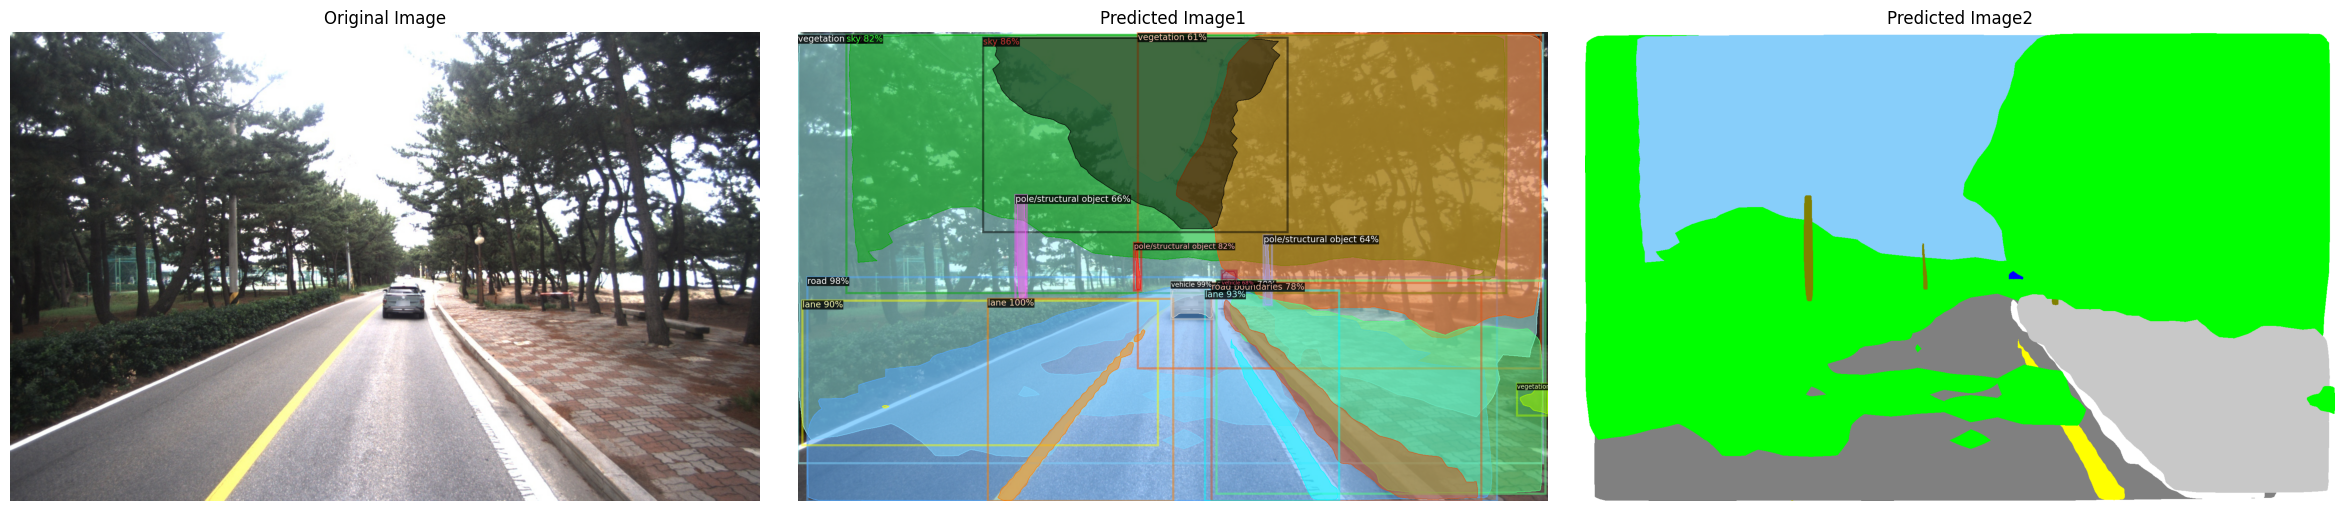

dataset/Preprocessed_2DSS/validation/coco/N_RRG_230714_016_FC_126.jpg


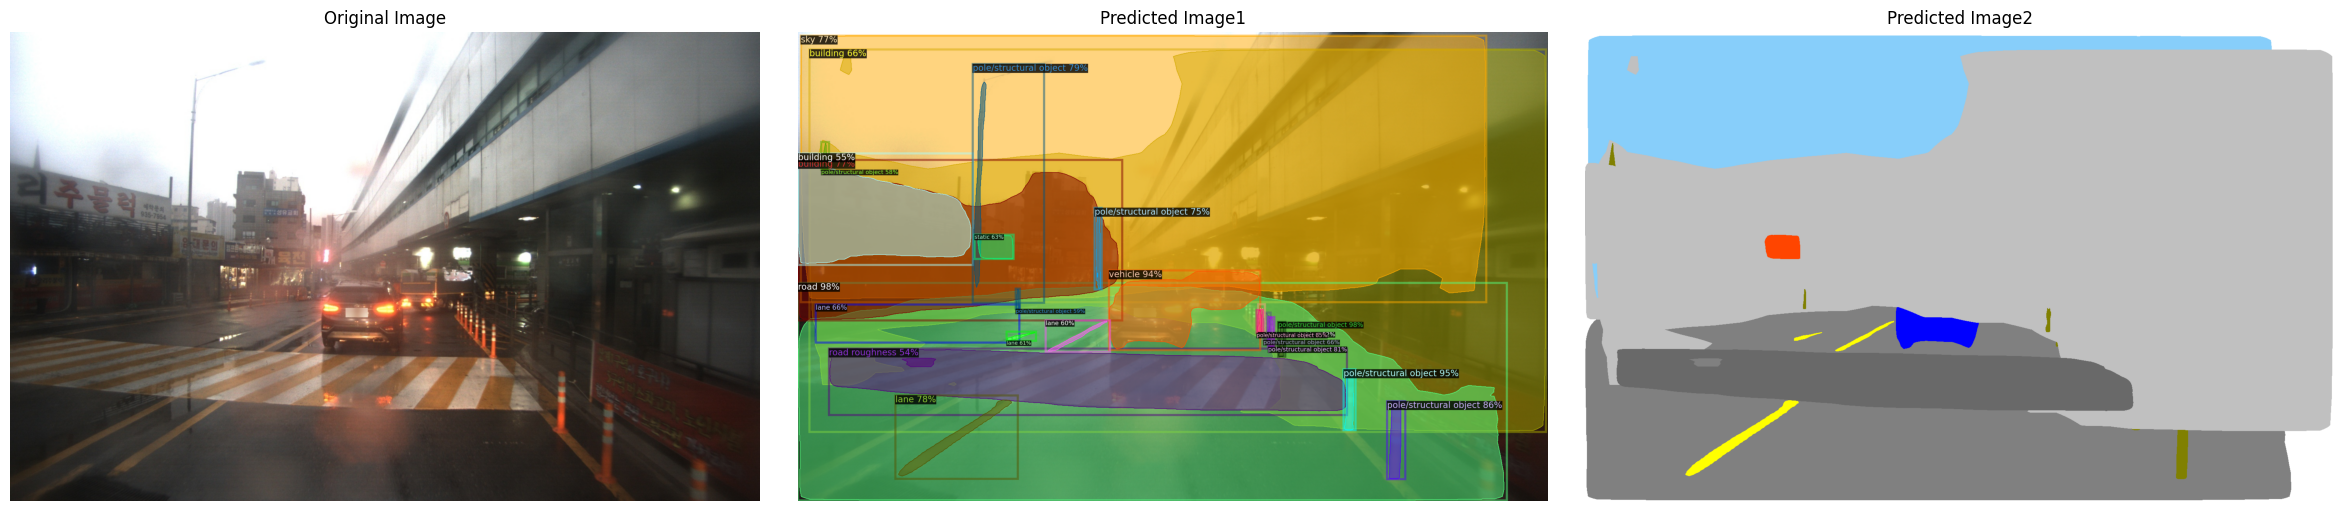

dataset/Preprocessed_2DSS/validation/coco/S_DRH_230629_018_FC_099.jpg


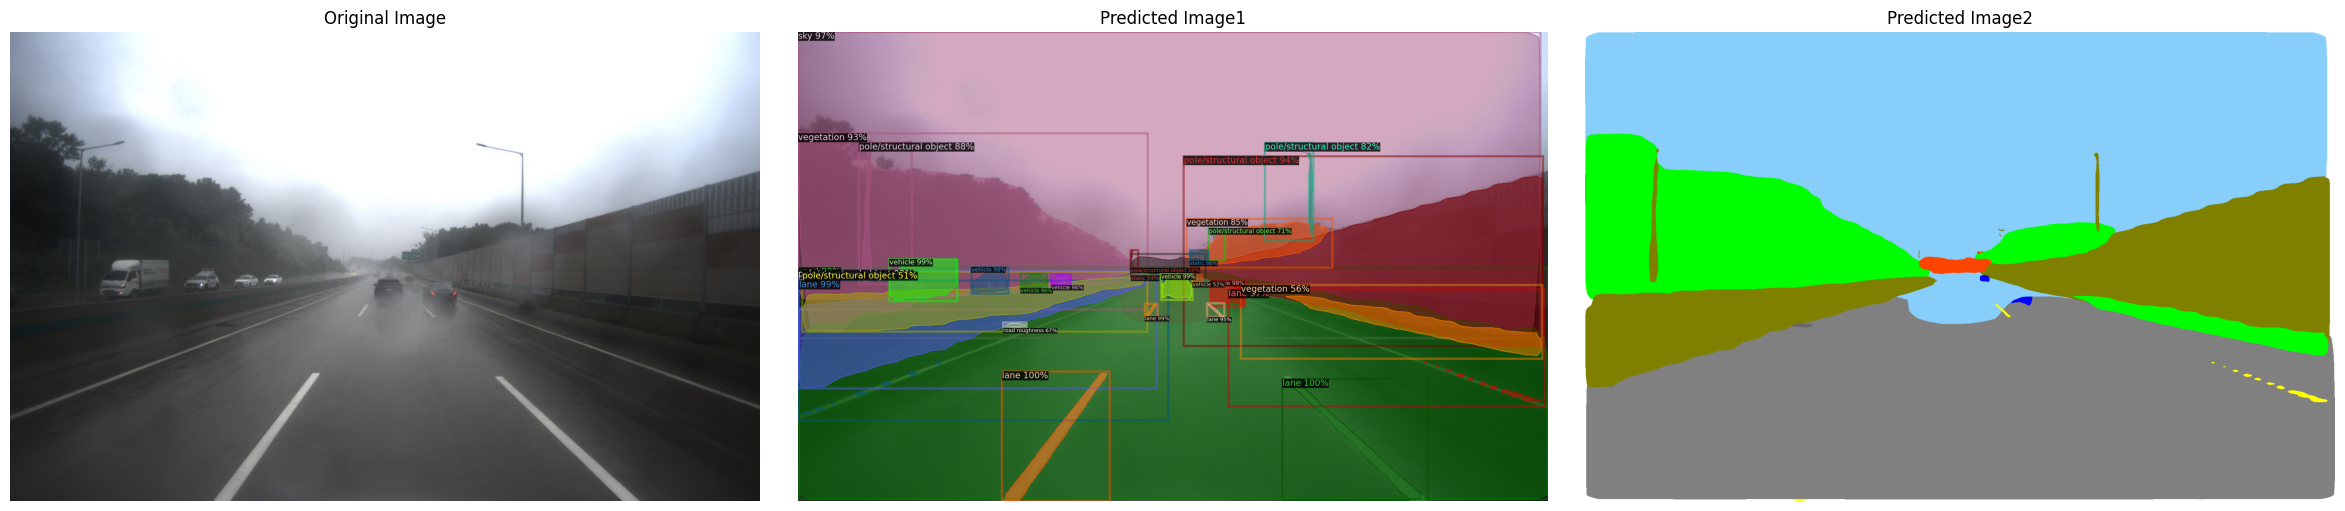

: 

In [52]:
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
dataset_dicts = DatasetCatalog.get(cfg.DATASETS.TEST[0])

for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    origin_im = cv2.imread(d["file_name"])
    print(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
        metadata=metadata, 
        scale=1.5, 
        #instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    masks = outputs["instances"].pred_masks.to("cpu").numpy()
    classes = outputs["instances"].pred_classes.to("cpu").numpy()
    im[:] = 255
    
    i = 0
    for mask, clas in zip(masks, classes):
        mask = masks[i]
        color = class_colors[clas]
        im[mask] = color
        i += 1
    
    plt.figure(figsize=(30,10))
    plt.subplot(1, 3, 1)
    plt.imshow(origin_im[:, :, ::-1])
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(out.get_image())
    plt.title("Predicted Image1")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(im)
    plt.title("Predicted Image2")
    plt.axis('off')
    
    plt.subplots_adjust(wspace=0.05, hspace=0)
    plt.show()